In [1]:
!wget -q https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip && unzip -q CARVANA.zip > /dev/null
!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!pip -q install colour

In [2]:
import os
from os.path import isfile, join
import cv2
import numpy as np
import pandas as pd
from colour import Color
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [3]:
class Carvana(Dataset):
    def __init__(self, root, transform=None):

        """
        :param root: путь к папке с данными
        :param transform: transform the images and labels
        """

        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path):

            """
            returns all the sorted image paths.
            :param path:
            :return: лист с путями до всех изображений
            """

            images_dir = [join(path, f) for f in os.listdir(path) if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + "/train")
        self.labels_path = load_images(self.root + "/train_masks")

    def __getitem__(self, index):

        """
        :param index:
        :return: tuple (img, target) with the input data and its label
        """

        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)

In [4]:
def im_show(img_list):

    """
    It receives a list of images and plots them together
    :param img_list:
    :return:
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    for (idx, img) in enumerate(img_list):
        img = np.array(to_PIL(img))
        #plt.subplot(100 + 10 * len(img_list) + idx + 1)
        plt.figure(figsize=(2, 2))
        fig = plt.imshow(img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()

In [5]:
train_dataset = Carvana(root=".",
                        transform=transforms.Compose([transforms.Resize((256, 256)),
                                                      transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

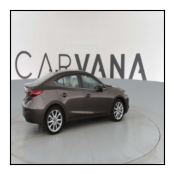

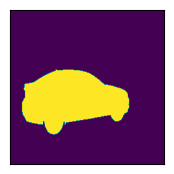

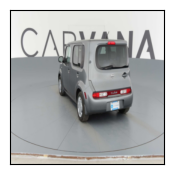

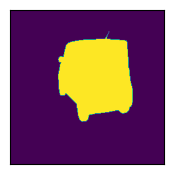

In [6]:
img_list = []
for i in range(2):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append(img)
    img_list.append(label)

im_show(img_list)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size,
                              kernel_size,
                              padding=padding,
                              stride=stride)

        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.down_1 = nn.Sequential(ConvBlock(3, 16),
                                    ConvBlock(16, 32, stride=2, padding=1))
        self.down_2 = nn.Sequential(ConvBlock(32, 64),
                                    ConvBlock(64, 128))
        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)
        self.up_2   = nn.Sequential(ConvBlock(256, 128),
                                    ConvBlock(128, 32))
        self.up_1   = nn.Sequential(ConvBlock(64, 64),
                                    ConvBlock(64, 32))
        self.output = nn.Sequential(ConvBlock(32, 16),
                                    ConvBlock(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = nn.functional.interpolate(out, scale_factor=2)
        return self.output(out)

In [8]:
def train(train_loader, model, criterion, epoch, num_epochs):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))

        loss = criterion(outputs, labels)

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(
            f"Loss: {round(loss.item(), 4)} "
            f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()

In [9]:
model = Unet().cuda()
criterion = (torch.nn.BCELoss().cuda())
optimizer = torch.optim.RMSprop(model.parameters(),
                                weight_decay=1e-4,
                                lr=1e-4,
                                momentum=0.9)

num_epochs = 5
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs)

Loss: 0.5702 Accuracy: 98.8931: 100%|██████████| 40/40 [02:33<00:00,  3.84s/it]


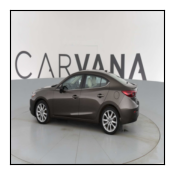

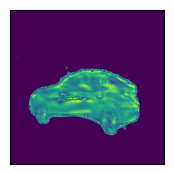

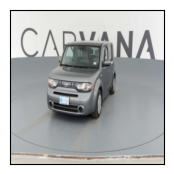

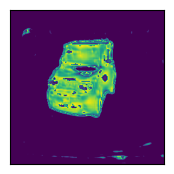

In [10]:
img_list = []
for i in range(2):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append(img)
    img_list.append(model(img.unsqueeze(0).cuda()).squeeze(0).cpu())

im_show(img_list)